# Run the MSAEXP pipeline steps for an example dataset from GO-4233 (RUBIES)

*Pipeline steps*

1. Query mast and download full-frame exposures (``rate.fits``)
1. Run the preprocessing pipline through extracting 2D cutouts
1. Combine and rectify the cutouts to a final stack
1. Extract 1D spectrum
1. (fit redshift, line fluxes, etc. (``spectral-extractions-2024.ipynb``)

In [68]:
# Are we on a GitHub codespace?
import os

if os.getcwd().startswith('/workspaces/msaexp'):
    import os
    os.environ['CRDS_PATH'] = os.path.join('/tmp/', 'crds_cache')

    if not os.path.exists(os.environ['CRDS_PATH']):
        ! mkdir {os.environ['CRDS_PATH']}

    os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

    print('On codespace: ', os.environ['CRDS_PATH'], os.environ['CRDS_SERVER_URL'])

    workdir  = '/workspaces/msaexp/docs/examples/codespace'
    if not os.path.exists(workdir):
        ! mkdir {workdir}
    
    os.chdir(workdir)
else:
    print('(not on a codespace)')

On codespace:  /tmp/crds_cache https://jwst-crds.stsci.edu


In [69]:
# CRDS variables
import os
if 'CRDS_PATH' not in os.environ is None:
    os.environ['CRDS_PATH'] = f'{os.getcwd()}/crds_cache'

    if not os.path.exists(os.environ['CRDS_PATH']):
        os.makedirs(os.environ['CRDS_PATH'])

    os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

In [70]:
try:
    import numba
except ImportError:
    ! pip install numba

In [71]:
import os
import glob
import yaml
import warnings
import time

import numpy as np
import matplotlib.pyplot as plt

import grizli
from grizli import utils, jwst_utils
jwst_utils.set_quiet_logging()
utils.set_warnings()

import astropy.io.fits as pyfits
import jwst.datamodels
import jwst

import mastquery.jwst

import msaexp
from msaexp import pipeline
import msaexp.slit_combine

print(f'jwst version = {jwst.__version__}')
print(f'grizli version = {grizli.__version__}')
print(f'msaexp version = {msaexp.__version__}')

plt.rcParams['scatter.marker'] = '.'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['grid.linestyle'] = ':'

jwst version = 1.14.0
grizli version = 1.11.6
msaexp version = 0.1.dev1+g44392ac


# Query MAST for NIRSpec data

Query by program name and download `rate.fits` files with `mastquery`.  May need to set `$MAST_TOKEN` environment variable to download proprietary datasets from MAST.

Can optionally limit the query to specific 

 - gratings:  ``prism``, ``g140m``, ``g235m``, ``g395m``, ``g140m``, ``g235m``, ``g395m``
 - filters:  ``clear``, ``f170lp``, ``f100lp``, ``f170lp``, ``f290lp``
 - detectors: ``nrs1``, ``nrs2``
 
 

In [72]:
## Optional
# Find the program, source_id based on a particular position
ra, dec = 214.97433534766, 52.92461350726

slits_url = f"https://grizli-cutout.herokuapp.com/nirspec_slits?coord={ra},{dec}"
slits = utils.read_catalog(slits_url, format='csv')

slits['program','msametfl','source_id','grating','footprint'][slits['is_source'] == 'True']

<GTable length=21>
program ...
 int64  ...
------- ...
   4233 ...
   4233 ...
   4233 ...
   4233 ...
   1345 ...
   4233 ...
   4233 ...
   1345 ...
   1345 ...
   1345 ...
   1345 ...
   1345 ...
   1345 ...
   1345 ...
   1345 ...
   1345 ...
   1345 ...
   1345 ...
   1345 ...
   1345 ...
   1345 ...

In [73]:
# JWST observing program ID
prog = 4233

# Single source for testing
source_ids = [44597]

# A single RUBIES mask
outroot = 'rubies-egs61'
mask_query = mastquery.jwst.make_query_filter('visit_id', values=['04233006001'])

gratings = ['prism']
detectors = ['nrs1'] # limit to NRS1 for the example

In [74]:
# Query NIRSpec data for a program name
files = glob.glob(f'jw0{prog}*rate.fits')

while len(files) == 0:
    print(time.ctime())
    masks = pipeline.query_program(prog,
        download=True,
        detectors=detectors,
        gratings=gratings,
        extensions=['uncal','s2d'],
        extra_filters=mask_query,
    )
    
    files = glob.glob(f'jw0{prog}*rate.fits')
    
    if len(files) == 0:
        time.sleep(30)

print(files)

['jw04233006001_03101_00002_nrs1_rate.fits', 'jw04233006001_03101_00003_nrs1_rate.fits', 'jw04233006001_03101_00004_nrs1_rate.fits']


In [75]:
# Unset DQ=4 pixels to avoid running ``snowblind`` for now
for file in files:
    with pyfits.open(file, mode='update') as im:
        im['DQ'].data -= (im['DQ'].data & 4)
        im.flush()

# Initialize pipeline

Exposures are grouped by detector and with a common `MSAMETFL` metadata file for the MSA setup.

## Preprocessing pipeline

1. Apply 1/f correction and identify "snowballs" on the `rate.fits` files
1. Remove "bias" (i.e., simple median) of each exposure
1. Rescale RNOISE array based on empty parts of the exposure
1. Run parts of the Level 2 JWST calibration pipeline ([calweb_spec2](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html#calwebb-spec2)):
    - [AssignWcs](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.assign_wcs.AssignWcsStep.html) : initialize WCS and populate slit bounding_box data
    - [Extract2dStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.extract_2d.Extract2dStep.html) : identify slits and set slit WCS
    - [FlatFieldStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.flatfield.FlatFieldStep.html#flatfieldstep) : slit-level flat field
    - [PathLossStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.pathloss.PathLossStep.html) : NIRSpec path loss
    - [BarShadowStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.barshadow.BarShadowStep.html#jwst.barshadow.BarShadowStep) : Bar Shadow
        - See also [MSAEXP PR#66](https://github.com/gbrammer/msaexp/pull/66)
    - [PhotomStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.photom.PhotomStep.html) : Photometric calibration
    - Note that the `srctype`, `master_background`, `wavecorr` steps are not performed.  The background subtraction is done manually on the 2D slit cutouts.
1. Parse slit metadata
1. Save slit cutout `SlitModel` files of the last pipeline step performed (`phot` = `PhotomStep`)

## Note! 

When the ``source_ids`` list is specified, the pipeline is only run for those sources in the MSA plan and will be much faster.  Set ``source_ids=None`` to extract *everything*.

In [76]:
SKIP_COMPLETED = True

for file in files:
    mode = '-'.join(file.split('_')[:4])    
    if (not os.path.exists(f'{mode}.slits.yaml')) & SKIP_COMPLETED:
        pipe = pipeline.NirspecPipeline(mode=mode, files=[file])

        pipe = pipeline.NirspecPipeline(mode=mode,
                                        files=[file],
                                        source_ids=source_ids,
                                        positive_ids=True # Ignore background slits
                                       ) 
        
        pipe.full_pipeline(run_extractions=False,
                           initialize_bkg=False,
                           load_saved=None,
                           scale_rnoise=True)
                
    else:
        print(f'Skip preprocessing: {mode}')

Skip preprocessing: jw04233006001-03101-00002-nrs1
Skip preprocessing: jw04233006001-03101-00003-nrs1
Skip preprocessing: jw04233006001-03101-00004-nrs1


The final result of the preprocessing pipeline are the SlitModel objects stored in individual ``*.phot.*fits`` files

In [77]:
phot_files = glob.glob(f'jw0{prog}*{source_ids[0]}.fits')
phot_files.sort()

print('\n'.join(phot_files))

jw04233006001_03101_00002_nrs1_phot.186.4233_44597.fits
jw04233006001_03101_00003_nrs1_phot.186.4233_44597.fits
jw04233006001_03101_00004_nrs1_phot.186.4233_44597.fits


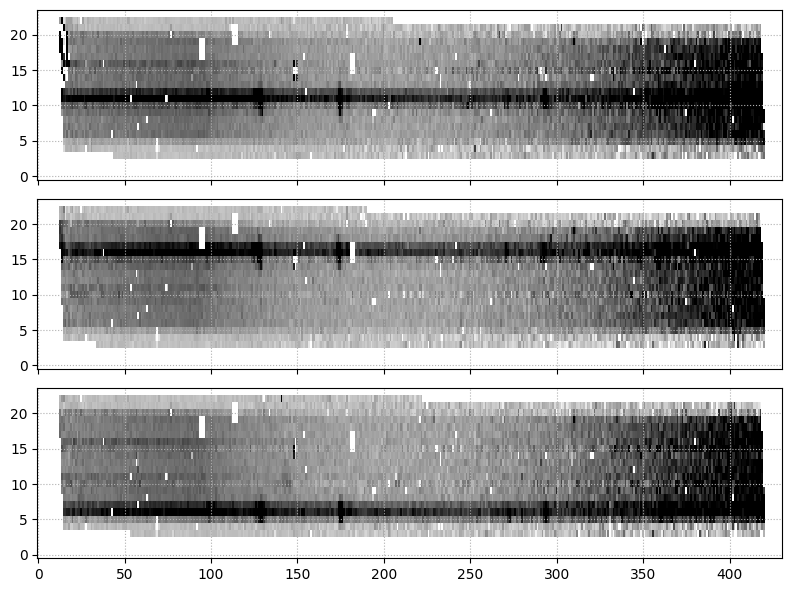

In [78]:
fig, axes = plt.subplots(3, 1, figsize=(8,6), sharex=True, sharey=True)

for ax, file in zip(axes, phot_files):
    dm = jwst.datamodels.open(file)
    ax.imshow(dm.data, vmin=-0.1, vmax=0.3, aspect='auto', cmap='gray_r')
    ax.grid()
    
fig.tight_layout(pad=1)

# Exposure combination and spectral extraction

In [79]:
obj = msaexp.slit_combine.SlitGroup?

Init signature:
msaexp.slit_combine.SlitGroup(
    files,
    name,
    position_key='position_number',
    diffs=True,
    grating_diffs=True,
    stuck_threshold=0.5,
    hot_cold_kwargs=None,
    bad_shutter_names=None,
    dilate_failed_open=True,
    undo_barshadow=False,
    min_bar=0.4,
    bar_corr_mode='wave',
    fix_prism_norm=True,
    sky_arrays=None,
    estimate_sky_kwargs=None,
    flag_profile_kwargs=None,
    undo_pathloss=True,
    trace_with_xpos=False,
    trace_with_ypos=True,
    trace_from_yoffset=False,
    fixed_offset=0.0,
    nod_offset=None,
    pad_border=2,
    weight_type='ivm',
    reference_exposure='auto',
    **kwargs,
)
Docstring:      <no docstring>
Init docstring:
Container for a list of 2D extracted ``SlitModel`` files

Parameters
----------
files : list
    List of `SlitModel` files

name : str
    Label for the group

position_key : str
    Column in the ``info`` table to define the nod positions
        - "y_index" = Rounded y offset
        -

In [80]:
group_kws = dict(
    diffs=True, # For nod differences
    undo_barshadow=2, # For msaexp barshadow correction
    min_bar=0.35, # minimum allowed value for the (inverse) bar shadow correction
    position_key="y_index",
    trace_with_ypos=True, # Include expected y shutter offset in the trace
    trace_from_yoffset=True,
    flag_profile_kwargs=None, # Turn off profile flag
)    

obj = msaexp.slit_combine.SlitGroup(
    phot_files,
    outroot,
    **group_kws,
)

 0 jw04233006001_03101_00002_nrs1_phot.186.4233_44597.fits (24, 431)
 1 jw04233006001_03101_00003_nrs1_phot.186.4233_44597.fits (24, 431)
 2 jw04233006001_03101_00004_nrs1_phot.186.4233_44597.fits (24, 431)
   jw04233006001_03101_00002_nrs1_phot.186.4233_44597.fits source_type=None  undo PATHLOSS_UN
   jw04233006001_03101_00003_nrs1_phot.186.4233_44597.fits source_type=None  undo PATHLOSS_UN
   jw04233006001_03101_00004_nrs1_phot.186.4233_44597.fits source_type=None  undo PATHLOSS_UN
 Recomputed offsets slit: force [ 0.00,  5.07, -5.07] pix offsets
 apply_spline_bar_correction(mode='wave')
 get_normalization_correction: prism_slit_renormalize.yaml quadrant=4 xcen=291 ycen=50


In [81]:
print(f"""
Number of exposures: {obj.N}
2D array shape: {obj.sh}
Flattened data array: {obj.sci.shape}
""")


Number of exposures: 3
2D array shape: (24, 431)
Flattened data array: (3, 10344)



Show the exposure data again now with the trace.

Also note that the sky is flatter than before with the updated bar shadow correction.

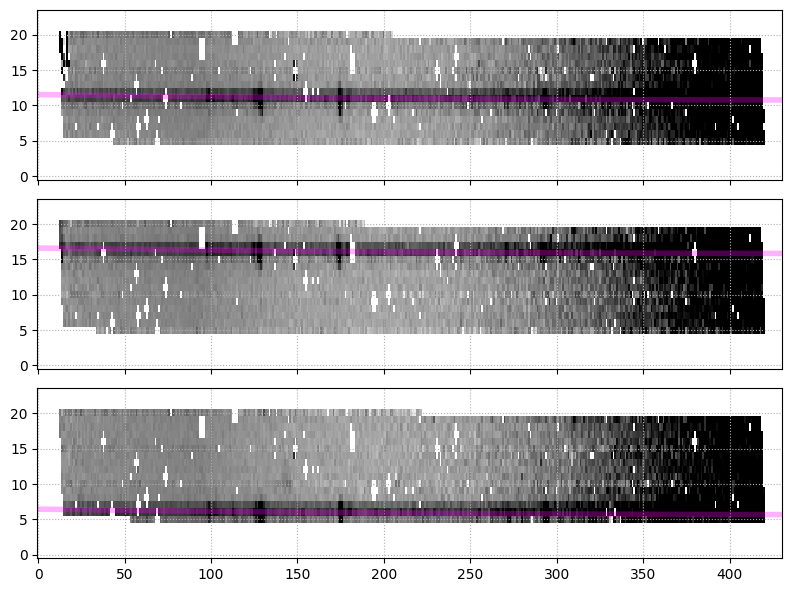

In [82]:
fig, axes = plt.subplots(obj.N, 1, figsize=(8,6), sharex=True, sharey=True)

for i, ax in enumerate(axes):
    ax.imshow(obj.sci[i,:].reshape(obj.sh), vmin=-0.1, vmax=0.3, aspect='auto', cmap='gray_r')
    ax.plot(obj.ytr[i,:], color='magenta', alpha=0.3, lw=4)
    ax.grid()
    
fig.tight_layout(pad=1)

## Fit the trace profile

The profile is modeled as a (pixel-integrated) Gaussian with a specified width that is added in quadrature with the tabulated 
PSF width.

In [83]:
obj.fit_all_traces?

Signature: obj.fit_all_traces(niter=3, dchi_threshold=-25, ref_exp=2, **kwargs)
Docstring:
Fit all traces in the group

Parameters
----------
niter : int
    Number of iterations for fitting the traces (default: 3)

dchi_threshold : float
    Threshold value for the change in chi-square to consider a fit
    (default: -25)

ref_exp : int
    Reference exposure for fitting the traces (default: 2)

kwargs : dict
    Additional keyword arguments for the fitting process

Returns
-------
tfits : dict
    Dictionary containing the fit results for each exposure group
File:      ~/.python/current/lib/python3.10/site-packages/msaexp/slit_combine.py
Type:      method

Signature: obj.fit_all_traces(niter=3, dchi_threshold=-25, ref_exp=2, **kwargs)
Docstring:
Fit all traces in the group

Parameters
----------
niter : int
    Number of iterations for fitting the traces (default: 3)

dchi_threshold : float
    Threshold value for the change in chi-square to consider a fit
    (default: -25)

ref_exp : int
    Reference exposure for fitting the traces (default: 2)

kwargs : dict
    Additional keyword arguments for the fitting process

Returns
-------
tfits : dict
    Dictionary containing the fit results for each exposure group
File:      ~/.python/current/lib/python3.10/site-packages/msaexp/slit_combine.py
Type:      method

In [ ]:
fit = obj.fit_all_traces(
    offset_degree=0, # order of the offset polynomial to fit
    force_positive=False,
    x0=[2, 0.], # Initial guess:  gaussian width in pixels x 10, trace offset pixels
    niter=1,
    ref_exp=obj.calc_reference_exposure
)

   fit_all_traces, iter 0
      91  sigma=2.00  [ 0.000]  5718.5
      92  sigma=6.09  [ 0.036]  3975.4
     Exposure group 2   dchi2 =   -1743.1

      93  sigma=6.09  [ 0.036]  4899.3
      94  sigma=6.09  [ 0.036]  4899.3
     Exposure group 1   dchi2 =       0.0

      95  sigma=6.09  [ 0.036]  4890.4
      96  sigma=6.09  [ 0.036]  4890.4
     Exposure group 3   dchi2 =       0.0



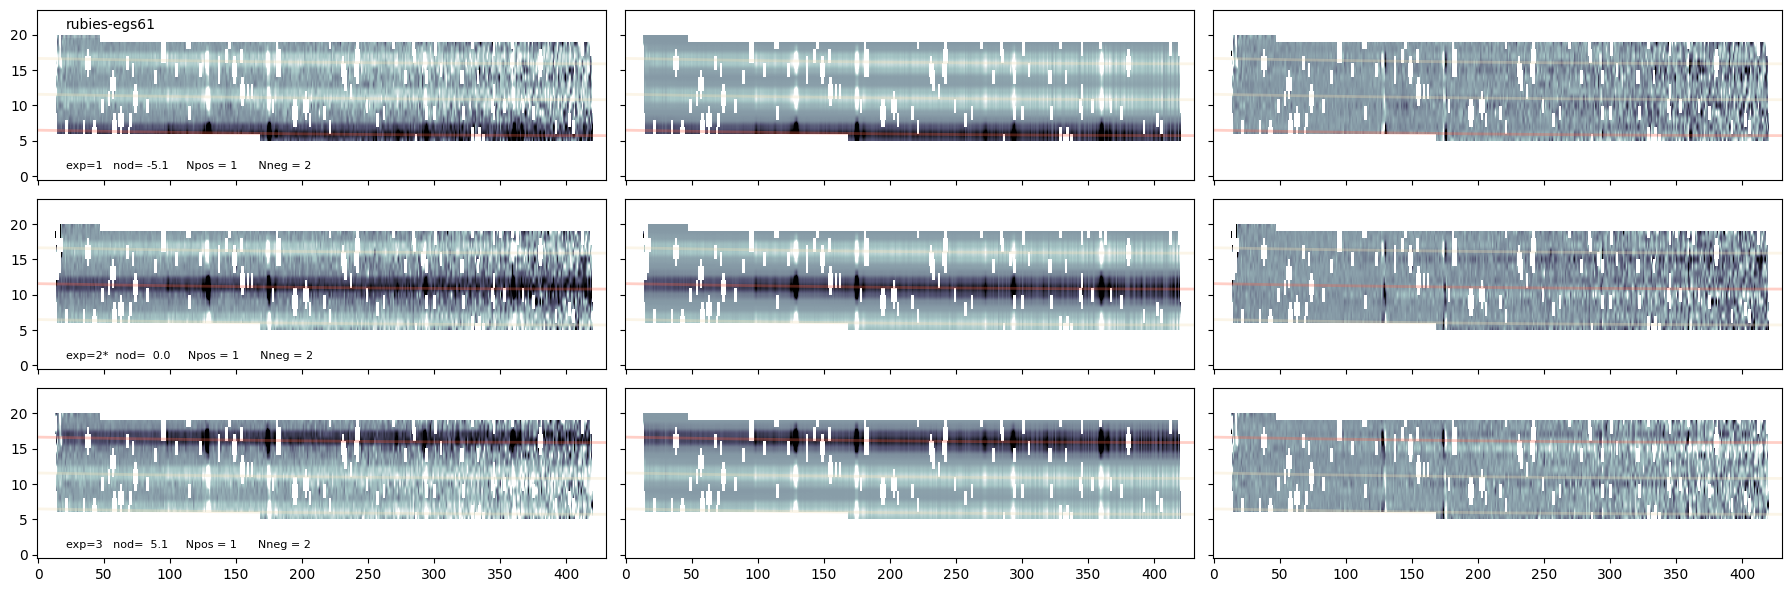

In [ ]:
# Show the profile fit
fig2d = obj.plot_2d_differences(fit=fit)

# Resample the spectra to a rectified pixel grid and get optimal 1D extraction

In [ ]:
drizzle_kws = dict(
    step=1, # cross dispersion step size
    ny=15, # number of cross dispersion pixels
    with_pathloss=True, # use MSAEXP path loss that accounts for source size
    wave_sample=1.05, # wavelength sampling
    dkws=dict(oversample=16, pixfrac=0.8),
)

hdul = msaexp.slit_combine.combine_grating_group(
    {'prism': {'obj':obj, 'fit': fit}},
     ['prism'],
     drizzle_kws=drizzle_kws
)


msaexp.drizzle.extract_from_hdul: Initial center =    0.00, sigma =   0.61
msaexp.drizzle.extract_from_hdul: dchi2/dcenter = 26234.0
msaexp.drizzle.extract_from_hdul: aperture extraction = (15, 1)
Added path_corr column to spec
msaexp.drizzle.extract_from_hdul:  Output center =   -0.00, sigma =   0.61


In [ ]:
hdul.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SPEC1D        1 BinTableHDU    335   435R x 5C   ['D', 'D', 'D', 'D', 'D']   
  2  SCI           1 ImageHDU       319   (435, 31)   float64   
  3  WHT           1 ImageHDU       319   (435, 31)   float64   
  4  PROFILE       1 ImageHDU       319   (435, 31)   float64   
  5  PROF1D        1 BinTableHDU     25   31R x 3C   ['D', 'D', 'D']   
  6  SLITS         1 BinTableHDU    103   3R x 47C   ['55A', 'K', 'K', 'D', 'D', 'D', 'D', 'D', 'K', '10A', 'D', 'D', 'D', 'D', '3A', 'K', 'K', 'D', 'D', 'K', 'K', 'K', 'K', 'K', 'K', 'K', '4A', '5A', '5A', '29A', 'K', 'K', 'D', 'K', 'K', 'K', '12A', 'D', 'D', 'D', 'D', '17A', 'K', '4A', 'K', 'D', 'D']   


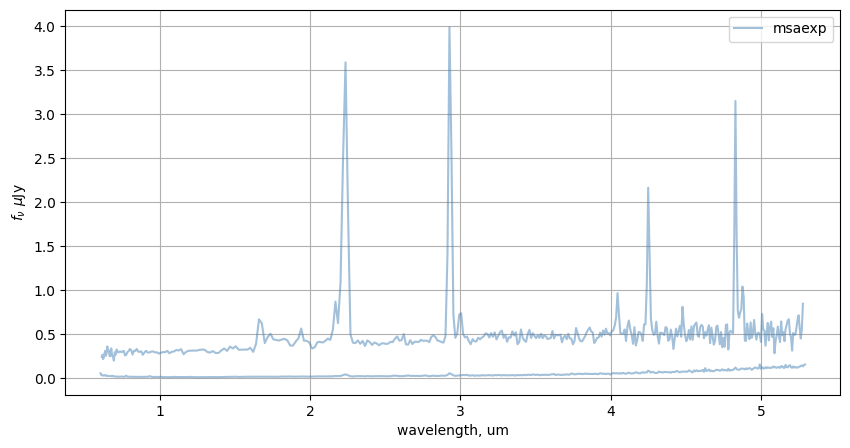

In [ ]:
spec = utils.read_catalog(hdul['SPEC1D'])

fig, ax = plt.subplots(1,1,figsize=(10,5))

pl = ax.plot(spec['wave'], spec['flux'], label='msaexp', color='steelblue', alpha=0.5)
ax.plot(spec['wave'], spec['err'], color=pl[0].get_color(), alpha=0.5)

ax.legend()

ax.set_xlabel('wavelength, um')
ax.set_ylabel(r'$f_\nu$ $\mu$Jy')
ax.grid()

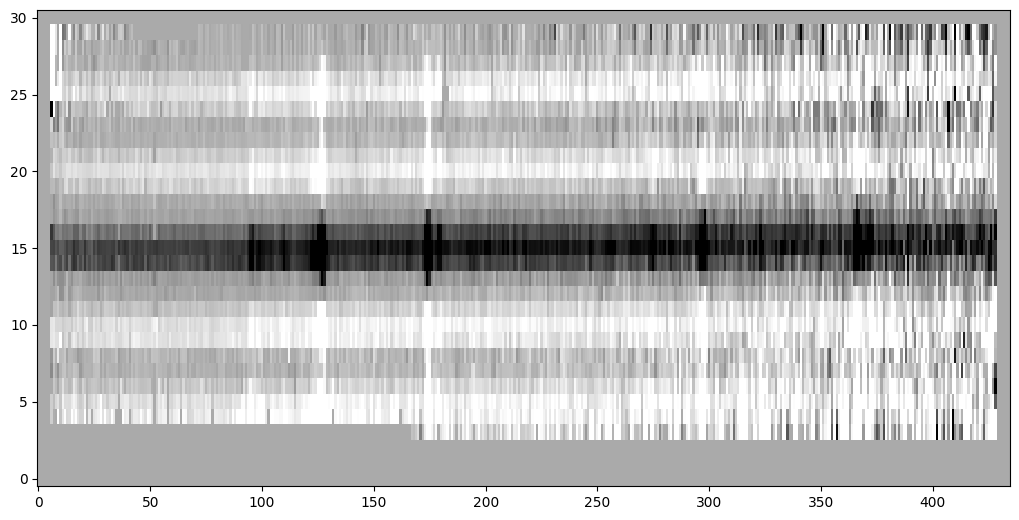

In [ ]:
# 2D 
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.imshow(hdul['SCI'].data, vmin=-0.1, vmax=0.2, aspect='auto', cmap='gray_r')
fig.tight_layout(pad=0)

## Estimate the sky directly from the spectrum

If the sky is well determined, this can eliminate the need to take the differences of the nodded exposure

In [ ]:
obj.estimate_sky?

Signature:
obj.estimate_sky(
    mask_yslit=[[-4.5, 4.5]],
    min_bar=0.95,
    var_percentiles=[-5, -5],
    df=51,
    high_clip=0.8,
    use=True,
    outlier_threshold=7,
    absolute_threshold=0.2,
    make_plot=False,
    **kwargs,
)
Docstring:
Estimate sky spectrum by fitting a flexible spline to all available pixels in
indicated empty shutter areas

Parameters
----------
mask_yslit : list of (float, float)
    Range of shutter pixels to exclude as coming from the source and/or
    contaminants

min_bar : float
    Minimum allowed value of the bar obscuration

var_percentiles : None, (float, float)
    Exclude sky pixels with variances outside of this percentile range.  If
    a negative number is provided, treat as an explicit number of pixels
    to exclude from the low and high sides.

df : int
    Degrees of freedom of the spline fit.  If ``df = 0``, then just compute
    a scalar normalization factor.  If ``df < 0``, then don't rescale at all.

use : bool
    Use the resul

 estimate_sky: N = 3568 , outliers > 7: 11


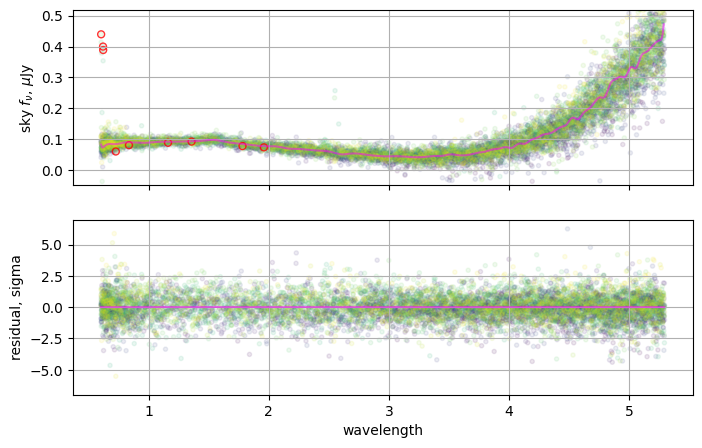

In [ ]:
estimate_sky_kwargs = dict(
    mask_yslit=[[-4.5, 4.5]], # mask pixels expected to contain the source
    min_bar=0.95,
    df=81, # number of splines to fit.  Needs to be high to fit the wiggles in the sky spectrum
    high_clip=1.0,
    make_plot=True,
)  

_ = obj.estimate_sky(**estimate_sky_kwargs)

The ``data`` attribute is ``sci - sky2d`` if ``sky2d`` is available

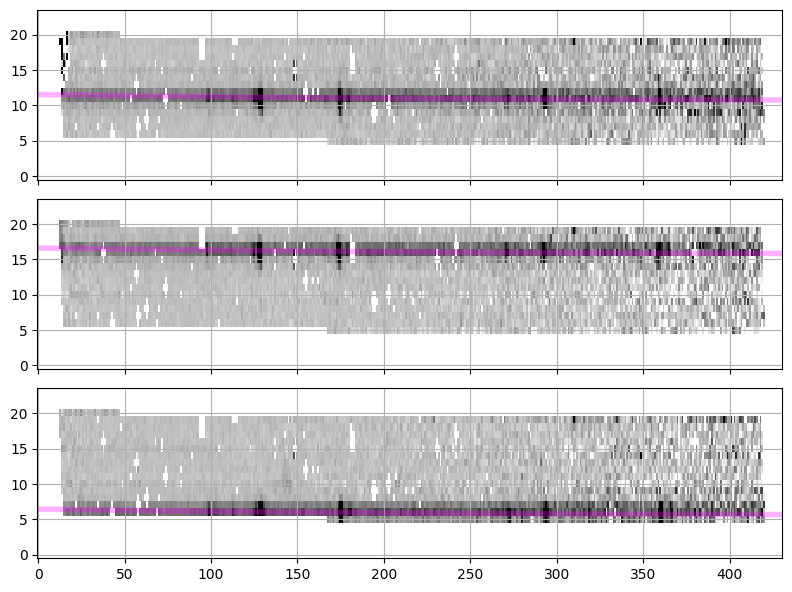

In [ ]:
fig, axes = plt.subplots(obj.N, 1, figsize=(8,6), sharex=True, sharey=True)

for i, ax in enumerate(axes):
    ax.imshow(obj.data[i,:].reshape(obj.sh), vmin=-0.1, vmax=0.3, aspect='auto', cmap='gray_r')
    ax.plot(obj.ytr[i,:], color='magenta', alpha=0.3, lw=4)
    ax.grid()
    
fig.tight_layout(pad=1)

## Flag outliers based on the cross-dispersion profile

In [ ]:
obj.flag_from_profile?

Signature:
obj.flag_from_profile(
    grow=2,
    nfilt=-32,
    require_multiple=True,
    make_plot=False,
)
Docstring:
Flag pixel outliers based on the cross-dispersion profile
- Calculate the p5, p50, and p95 rolling percentiles across the profile
- Flag high pixels where ``value > p95 + (p95 - p50)*grow``
- Flag low pixels where ``value < min(p5, 0) - 5 * sigma``

Parameters
----------
grow : float

nfilt : int
    Size of the filter window for the profile.  If ``nfilt < 0``, then interpret
    as ``nfilt = self.mask.sum() // -nfilt``, otherwise use directly as the
    filter size

require_multiple : bool
    Require that flagged pixels appear in multiple exposures

make_plot : bool
    Make a diagnostic figure

Returns
-------
updates the ``mask`` attribute
File:      ~/.python/current/lib/python3.10/site-packages/msaexp/slit_combine.py
Type:      method

 flag_from_profile: 9 ( 0.1%) pixels


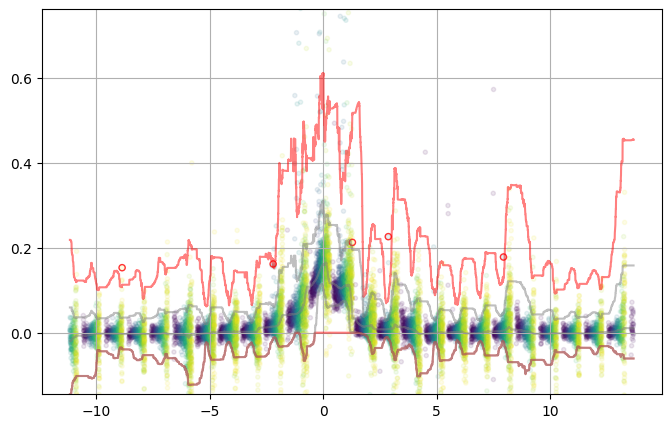

In [ ]:
flag_profile_kwargs = dict(require_multiple=True, make_plot=True, grow=2, nfilt=-32)
obj.flag_from_profile(**flag_profile_kwargs)

## Turn off exposure differences and do resample and extraction again

In [ ]:
obj.meta["diffs"] = False

In [ ]:
drizzle_kws = dict(
    step=1, # cross dispersion step size
    ny=15, # number of cross dispersion pixels
    with_pathloss=True, # use MSAEXP path loss that accounts for source size
    wave_sample=1.05, # wavelength sampling
    dkws=dict(oversample=16, pixfrac=0.8),
)

hdul_nodiff = msaexp.slit_combine.combine_grating_group(
    {'prism': {'obj':obj, 'fit': fit}},
     ['prism'],
     drizzle_kws=drizzle_kws
)


msaexp.drizzle.extract_from_hdul: Initial center =    0.00, sigma =   0.61
msaexp.drizzle.extract_from_hdul: dchi2/dcenter = 34986.5
msaexp.drizzle.extract_from_hdul: aperture extraction = (15, 1)
Added path_corr column to spec
msaexp.drizzle.extract_from_hdul:  Output center =   -0.00, sigma =   0.61


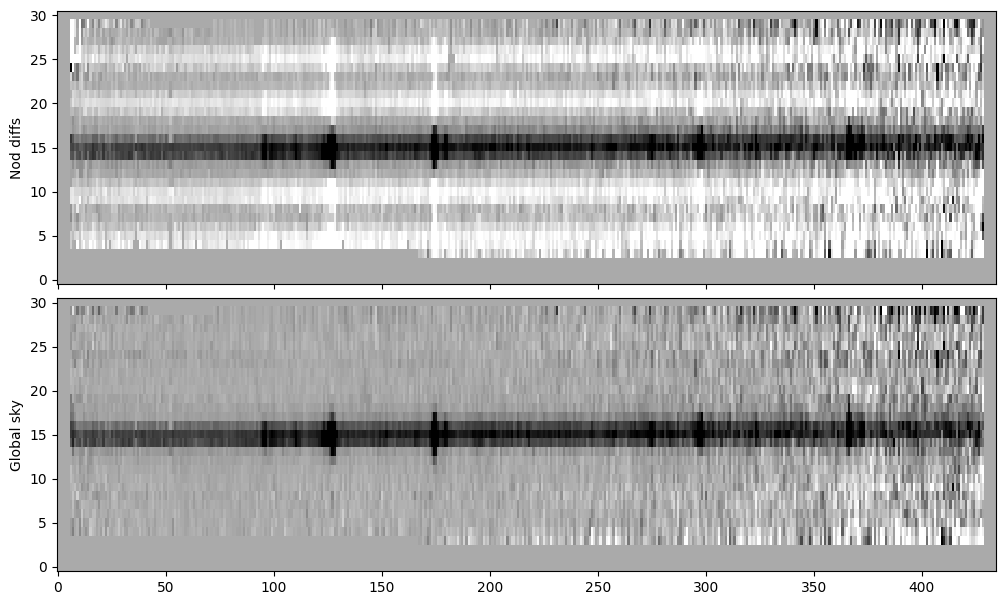

In [ ]:
# 2D 
fig, axes = plt.subplots(2,1,figsize=(10,6), sharex=True, sharey=True)
kws = dict(vmin=-0.1, vmax=0.2, aspect='auto', cmap='gray_r')

axes[0].imshow(hdul['SCI'].data, **kws)
axes[0].set_ylabel('Nod diffs')

axes[1].imshow(hdul_nodiff['SCI'].data, **kws)
axes[1].set_ylabel('Global sky')

fig.tight_layout(pad=0.5)

# Combination and extraction wrapped into a single script

In [ ]:
msaexp.slit_combine.extract_spectra?

Signature:
msaexp.slit_combine.extract_spectra(
    target='1208_5110240',
    root='nirspec',
    path_to_files='./',
    files=None,
    do_gratings=['PRISM', 'G395H', 'G395M', 'G235M', 'G140M'],
    join=[0, 3, 5],
    split_uncover=True,
    stuck_threshold=0.0,
    pad_border=2,
    sort_by_sn=False,
    position_key='y_index',
    mask_cross_dispersion=None,
    cross_dispersion_mask_type='trace',
    trace_from_yoffset=False,
    reference_exposure='auto',
    trace_niter=4,
    offset_degree=0,
    degree_kwargs={},
    recenter_all=False,
    nod_offset=None,
    initial_sigma=7,
    fit_type=1,
    initial_theta=None,
    fix_params=False,
    input_fix_sigma=None,
    fit_params_kwargs=None,
    diffs=True,
    undo_pathloss=True,
    undo_barshadow=False,
    sky_arrays=None,
    use_first_sky=False,
    drizzle_kws={'step': 1, 'with_pathloss': True, 'wave_sample': 1.05, 'ny': 13, 'dkws': {'oversample': 16, 'pixfrac': 0.8}},
    get_xobj=False,
    trace_with_xpos=False,
  

# (2024-05-16 13:42:12.656)

slit_combine.extract_spectra(**{'target': '4233_44597', 'root': 'rubies-egs61', 'path_to_files': './', 'files': None, 'do_gratings': ['PRISM', 'G395H', 'G395M', 'G235M', 'G140M'], 'join': [0, 3, 5], 'split_uncover': True, 'stuck_threshold': 0.0, 'pad_border': 2, 'sort_by_sn': False, 'position_key': 'y_index', 'mask_cross_dispersion': None, 'cross_dispersion_mask_type': 'trace', 'trace_from_yoffset': True, 'reference_exposure': 'auto', 'trace_niter': 4, 'offset_degree': 0, 'degree_kwargs': {}, 'recenter_all': False, 'nod_offset': None, 'initial_sigma': 7, 'fit_type': 1, 'initial_theta': None, 'fix_params': False, 'input_fix_sigma': None, 'fit_params_kwargs': None, 'diffs': True, 'undo_pathloss': True, 'undo_barshadow': 2, 'use_first_sky': False, 'drizzle_kws': {'step': 1, 'with_pathloss': True, 'wave_sample': 1.05, 'ny': 13, 'dkws': {'oversample': 16, 'pixfrac': 0.8}}, 'get_xobj': False, 'trace_with_xpos': False, 'trace_with_ypos': True, 'get_background': Fa

2024-05-16 13:42:18,635 - stpipe - WARNING - /home/codespace/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(

2024-05-16 13:42:18,637 - stpipe - WARNING - /home/codespace/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)



rubies-egs61_prism-clear_4233_44597.spec.fits


2024-05-16 13:42:19,389 - stpipe - WARNING - /home/codespace/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(

2024-05-16 13:42:19,391 - stpipe - WARNING - /home/codespace/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)



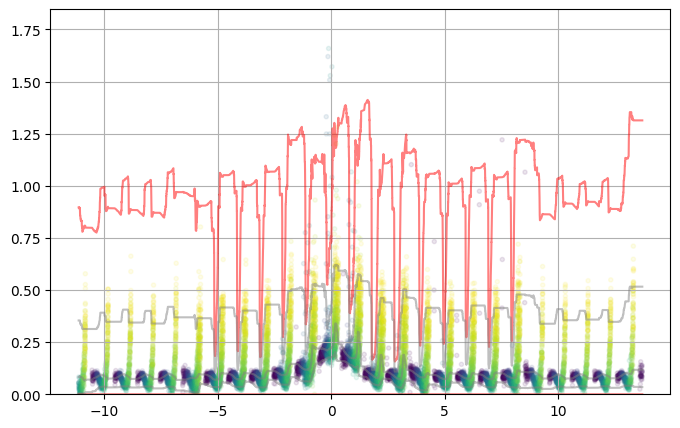

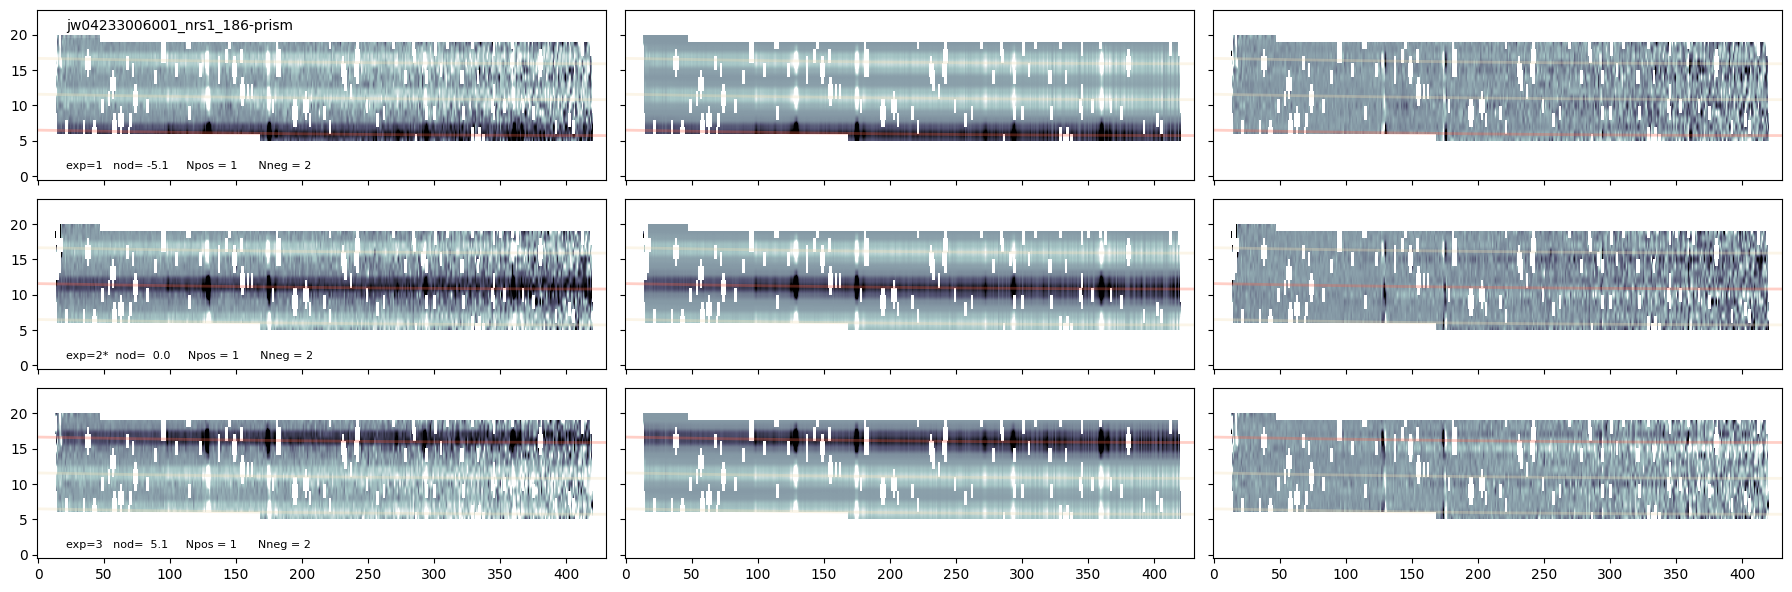

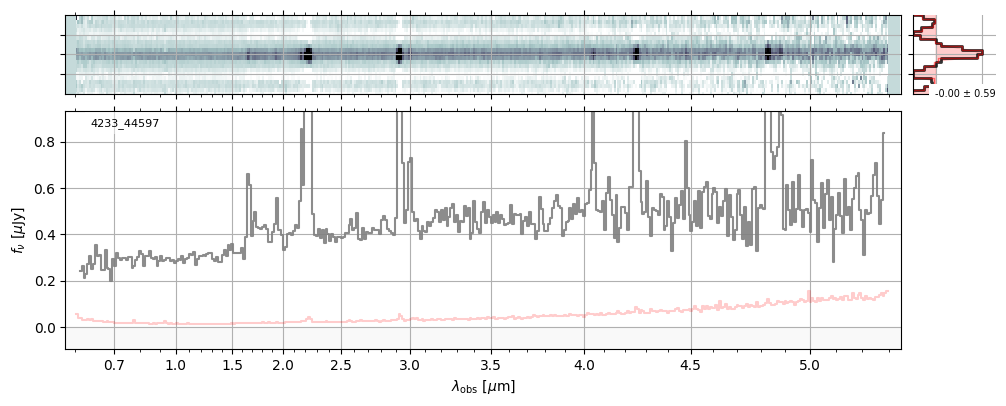

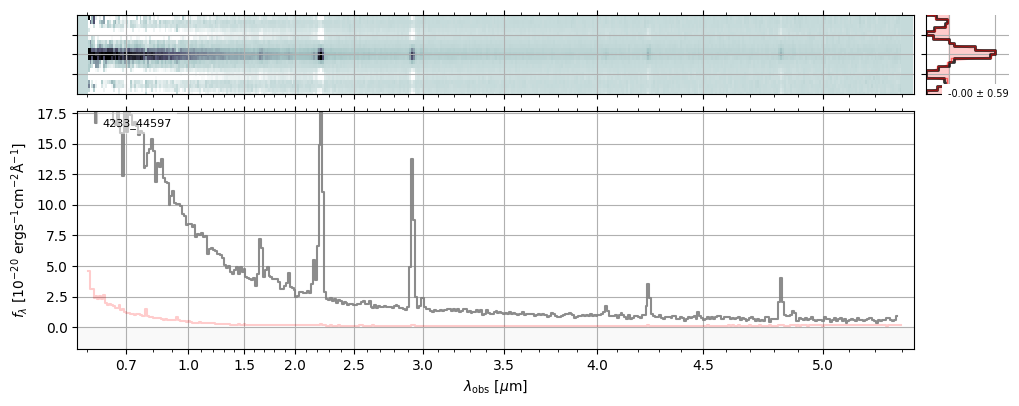

In [ ]:
group_kws['diffs'] = True
group_kws['flag_profile_kwargs'] = flag_profile_kwargs

target=f'{prog}_{source_ids[0]}'

_ = msaexp.slit_combine.extract_spectra(
    target=target,
    root=outroot,
    **group_kws,
)

# (2024-05-16 13:42:22.040)

slit_combine.extract_spectra(**{'target': '4233_44597', 'root': 'rubies-egs61', 'path_to_files': './', 'files': None, 'do_gratings': ['PRISM', 'G395H', 'G395M', 'G235M', 'G140M'], 'join': [0, 3, 5], 'split_uncover': True, 'stuck_threshold': 0.0, 'pad_border': 2, 'sort_by_sn': False, 'position_key': 'y_index', 'mask_cross_dispersion': None, 'cross_dispersion_mask_type': 'trace', 'trace_from_yoffset': True, 'reference_exposure': 'auto', 'trace_niter': 4, 'offset_degree': 0, 'degree_kwargs': {}, 'recenter_all': False, 'nod_offset': None, 'initial_sigma': 7, 'fit_type': 1, 'initial_theta': None, 'fix_params': False, 'input_fix_sigma': None, 'fit_params_kwargs': None, 'diffs': False, 'undo_pathloss': True, 'undo_barshadow': 2, 'use_first_sky': False, 'drizzle_kws': {'step': 1, 'with_pathloss': True, 'wave_sample': 1.05, 'ny': 13, 'dkws': {'oversample': 16, 'pixfrac': 0.8}}, 'get_xobj': False, 'trace_with_xpos': False, 'trace_with_ypos': True, 'get_background': F

2024-05-16 13:42:28,009 - stpipe - WARNING - /home/codespace/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(

2024-05-16 13:42:28,010 - stpipe - WARNING - /home/codespace/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)



rubies-egs61_prism-clear_4233_44597.spec.fits


2024-05-16 13:42:28,445 - stpipe - WARNING - /home/codespace/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(

2024-05-16 13:42:28,447 - stpipe - WARNING - /home/codespace/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)



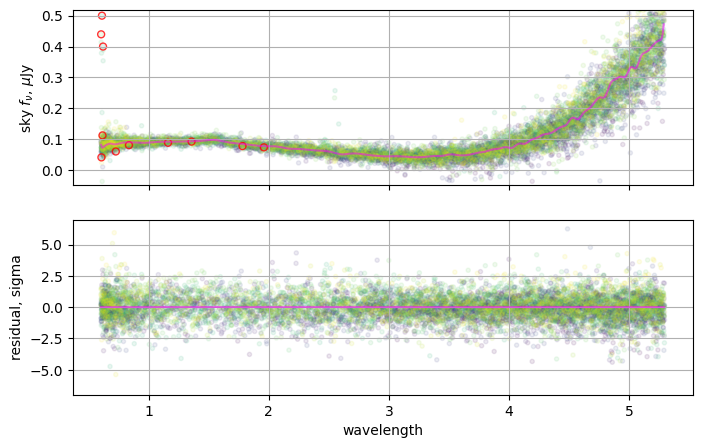

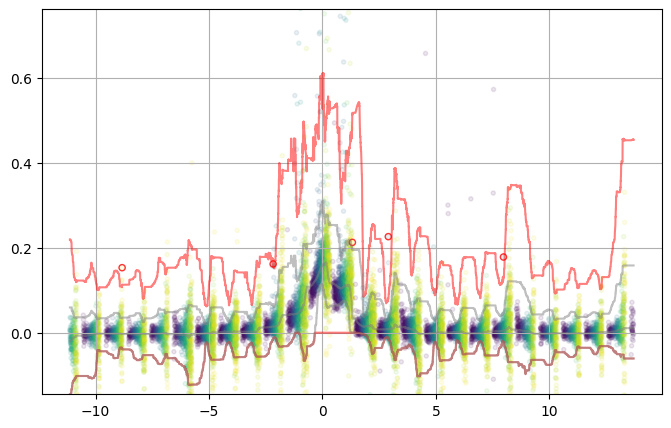

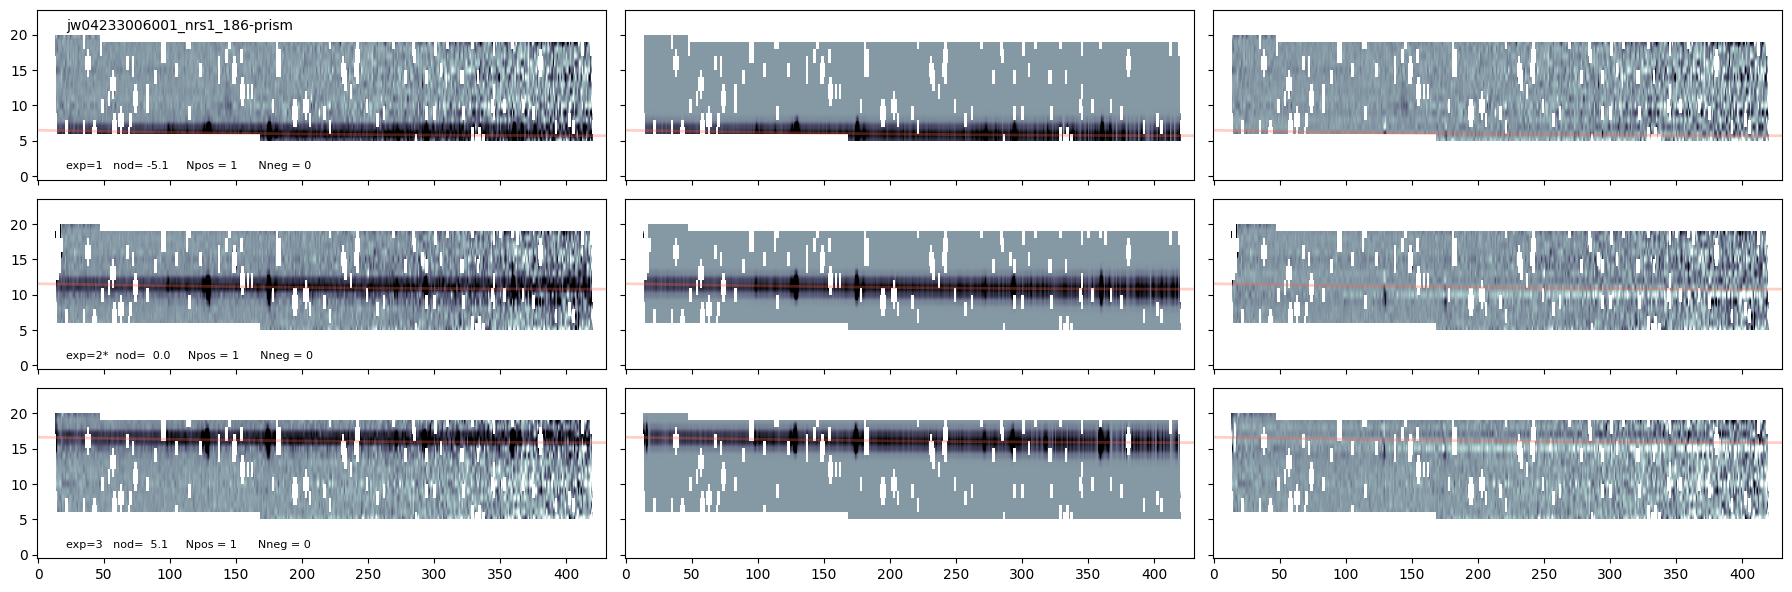

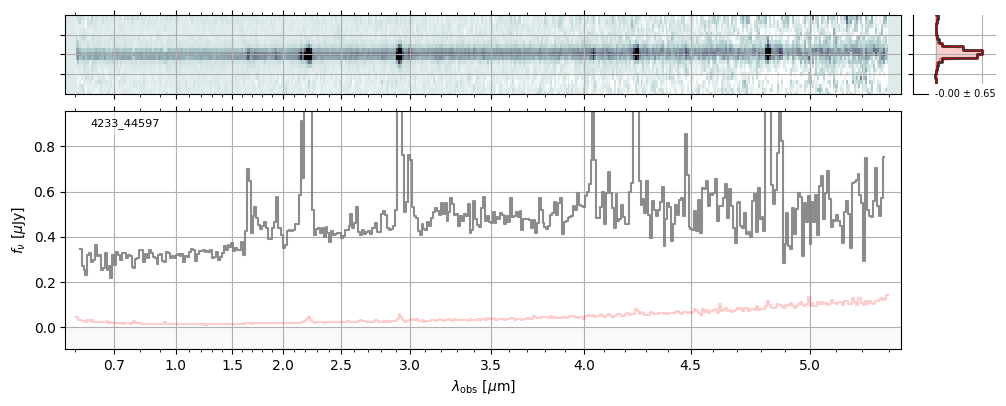

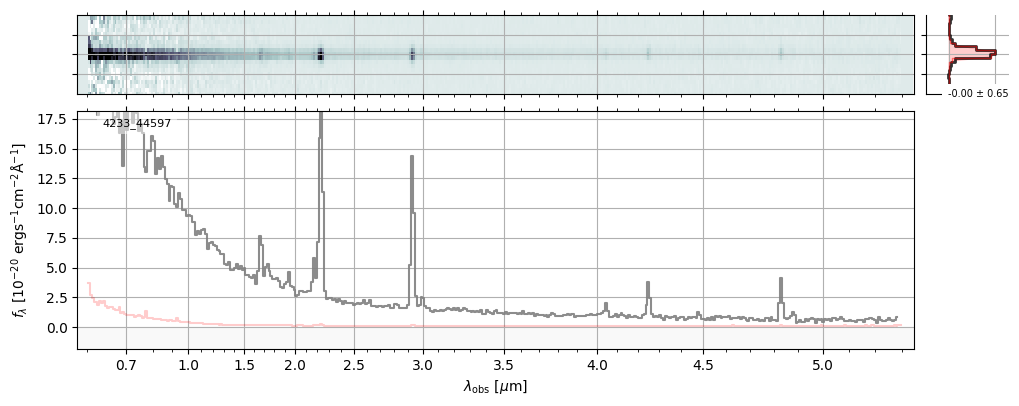

In [ ]:
# With sky estimation
group_kws['diffs'] = False

_ = msaexp.slit_combine.extract_spectra(
    target=target,
    root=outroot,
    estimate_sky_kwargs=estimate_sky_kwargs,
    **group_kws,
)

In [ ]:
! ls *{target}.*

jw04233006001_03101_00002_nrs1_phot.186.4233_44597.fits
jw04233006001_03101_00003_nrs1_phot.186.4233_44597.fits
jw04233006001_03101_00004_nrs1_phot.186.4233_44597.fits
rubies-egs61_4233_44597.extract.log
rubies-egs61_4233_44597.extract.yml
rubies-egs61_prism-clear_4233_44597.d2d.png
rubies-egs61_prism-clear_4233_44597.flam.png
rubies-egs61_prism-clear_4233_44597.fnu.png
rubies-egs61_prism-clear_4233_44597.spec.fits


# Fitting and analysis

Now go to the ``spectral-extractions-2024.ipynb`` notebook for a demo on fitting the spectra for redshift, lines, etc.